# 情绪分析和数据集
:label:`sec_sentiment`

随着在线社交媒体和评论平台的激增，已经记录了大量有意见的数据，这些数据在支持决策过程方面具有巨大潜力。
*情绪分析 *
研究人们在制作的文本中的情绪，例如产品评论、博客评论和论坛讨论。它广泛应用于政治（例如公众对政策的情绪分析）、金融（例如，市场情绪分析）和市场营销（例如，产品研究和品牌管理）等多样化领域。 

由于情绪可以归类为离散极性或尺度（例如正面和负面），因此我们可以将情绪分析视为一项文本分类任务，它将长度不同的文本序列转换为固定长度的文本类别。在本章中，我们将使用斯坦福大学的 [大型电影评论数据集]（https://ai.stanford.edu/~amaas/data/sentiment/）进行情绪分析。它包括一套培训集和一套测试集，其中包含从 IMDB 下载的 25000 个电影评论。在这两个数据集中，有相同数量的 “正” 和 “负面” 标签，表明情绪极性不同。


In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l


##  阅读数据集

首先，在路径 `../data/aclImdb` 中下载并提取此 IMDB 评论数据集。


In [2]:
#@save
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

接下来，阅读训练和测试数据集。每个例子都是评论及其标签：1 表示 “正面”，0 表示 “负面”。


In [3]:
#@save
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[0:60])

# trainings: 25000
label: 1 review: Normally the best way to annoy me in a film is to include so
label: 1 review: The Bible teaches us that the love of money is the root of a
label: 1 review: Being someone who lists Night of the Living Dead at number t


## 预处理数据集

将每个单词视为标记并过滤掉出现少于 5 次的单词，我们从训练数据集中创建一个词汇表。


In [4]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

标记化后，让我们绘制代币中的评论长度的直方图。


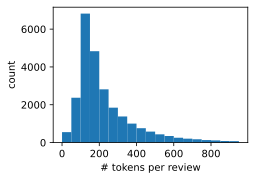

In [5]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

正如我们预期的那样，审查的长度不同。为了每次处理此类评论的小批次，我们将每次审阅的长度设置为 500，包括截断和填充，这与 :numref:`sec_machine_translation` 中的机器翻译数据集的预处理步骤类似。


In [6]:
num_steps = 500  # sequence length
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


## 创建数据迭代器

现在我们可以创建数据迭代器。在每次迭代中，都会返回一个小批示例。


In [7]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


## 把所有东西放在一起

最后，我们将上述步骤总结到 `load_data_imdb` 函数中。它返回训练和测试数据迭代器以及 IMDB 审查数据集的词汇。


In [8]:
#@save
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

## 摘要

* 情绪分析研究人们在他们制作的文本中的情绪，这被视为转换长度不同文本序列的文本分类问题
进入固定长度的文本类别。
* 预处理后，我们可以将斯坦福大型电影评论数据集（IMDB 评论数据集）加载到带有词汇的数据迭代器中。

## 练习

1. 我们可以修改本节中的哪些超参数来加快情绪分析模型的训练？
1. 你能实现一个函数来将 [Amazon reviews](https://snap.stanford.edu/data/web-Amazon.html) 的数据集加载到数据迭代器和标签中以进行情感分析吗？


[Discussions](https://discuss.d2l.ai/t/1387)
